In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from scipy.stats import randint, uniform
import warnings
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
warnings.filterwarnings('ignore')

**Preprocessing**

In [244]:
df = pd.read_csv(r"D:\ML\Assignment\Assignment 3\data\employee_data.csv")
df.head()

,employee_id,age,gender,marital_status,salary,employment_type,region,has_dependents,tenure_years,enrolled
0,10001,60,Female,Single,55122.97,Part-time,West,No,1.5,0
1,10002,50,Female,Single,89549.66,Full-time,West,Yes,12.8,1
2,10003,36,Male,Divorced,74145.66,Part-time,Midwest,No,3.8,0
3,10004,64,Female,Married,53877.83,Full-time,Northeast,No,3.3,0
4,10005,29,Male,Single,63404.63,Contract,Midwest,Yes,10.0,0


In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   employee_id      10000 non-null  int64  
 1   age              10000 non-null  int64  
 2   gender           10000 non-null  object 
 3   marital_status   10000 non-null  object 
 4   salary           10000 non-null  float64
 5   employment_type  10000 non-null  object 
 6   region           10000 non-null  object 
 7   has_dependents   10000 non-null  object 
 8   tenure_years     10000 non-null  float64
 9   enrolled         10000 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 781.4+ KB


In [246]:
df.sum().duplicated()

employee_id        False
age                False
gender             False
marital_status     False
salary             False
employment_type    False
region             False
has_dependents     False
tenure_years       False
enrolled           False
dtype: bool

In [247]:
df.isnull().sum()

employee_id        0
age                0
gender             0
marital_status     0
salary             0
employment_type    0
region             0
has_dependents     0
tenure_years       0
enrolled           0
dtype: int64

enrolled
1    0.6174
0    0.3826
Name: proportion, dtype: float64


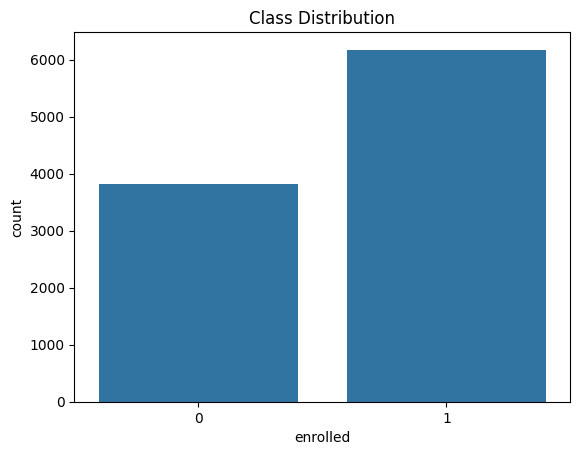

In [248]:
print(df["enrolled"].value_counts(normalize=True))
sns.countplot(data=df, x="enrolled")
plt.title("Class Distribution")
plt.show()

In [249]:
X = df.drop(columns=["employee_id", "enrolled"])
y = df["enrolled"]

**One Hot Encoding**

In [250]:
categorical_features = ['gender', 'marital_status', 'employment_type', 'region', 'has_dependents']
numerical_features = ['age', 'salary', 'tenure_years']

In [251]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)

**Train/Test Split**

In [252]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

**Hyperparameter Tuning**

In [253]:
# Random Forest Tuning
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])


In [254]:
rf_params = {
    'classifier__n_estimators': randint(100, 300),
    'classifier__max_depth': randint(3, 15),
    'classifier__min_samples_split': randint(2, 10),
    'classifier__min_samples_leaf': randint(1, 5)
}

In [255]:
rf_search = RandomizedSearchCV(rf_pipeline, rf_params, n_iter=10, cv=3, scoring='accuracy', random_state=42, verbose=1)
rf_search.fit(X_train, y_train)
print("Best Random Forest Params:", rf_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
# XGBoost Tuning
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

In [ ]:
xgb_params = {
    'classifier__n_estimators': randint(100, 300),
    'classifier__max_depth': randint(3, 10),
    'classifier__learning_rate': uniform(0.01, 0.3),
    'classifier__subsample': uniform(0.6, 0.4)
}

In [ ]:
xgb_search = RandomizedSearchCV(xgb_pipeline, xgb_params, n_iter=10, cv=3, scoring='accuracy', random_state=42, verbose=1)
xgb_search.fit(X_train, y_train)
print("Best XGBoost Params:", xgb_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best XGBoost Params: {'classifier__learning_rate': 0.12236203565420874, 'classifier__max_depth': 7, 'classifier__n_estimators': 114, 'classifier__subsample': 0.892797576724562}


**Final Model Evaluation with MLflow**

In [ ]:
client = MlflowClient()
models = {
    "Logistic Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000))
    ]),
    "Tuned Random Forest": rf_search.best_estimator_,
    "Tuned XGBoost": xgb_search.best_estimator_
}

In [ ]:
for name, model in models.items():
    print(f"\nTraining {name}...")

    with mlflow.start_run(run_name=name):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)


Training Logistic Regression...

Training Tuned Random Forest...

Training Tuned XGBoost...


In [ ]:
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"=== {name} ===")
print(classification_report(y_test, y_pred))
print("Accuracy:", acc)
print("F1 Score:", f1)

=== Tuned XGBoost ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       765
           1       1.00      1.00      1.00      1235

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Accuracy: 0.9995
F1 Score: 0.9995953055443141


**Feature Importance**

In [ ]:
def plot_feature_importance(model, model_name, feature_names):
    if hasattr(model.named_steps['classifier'], "feature_importances_"):
        importances = model.named_steps['classifier'].feature_importances_
        indices = np.argsort(importances)[::-1]
        names = np.array(feature_names)[indices]
        plt.figure(figsize=(10, 6))
        sns.barplot(x=importances[indices], y=names)
        plt.title(f"Feature Importance: {model_name}")
        plt.xlabel("Importance Score")
        plt.show()

In [ ]:
# Get feature names after preprocessing
ohe = models["Tuned Random Forest"].named_steps['preprocessor'].named_transformers_['cat']
encoded_cat = ohe.get_feature_names_out(categorical_features)
all_features = list(encoded_cat) + numerical_features

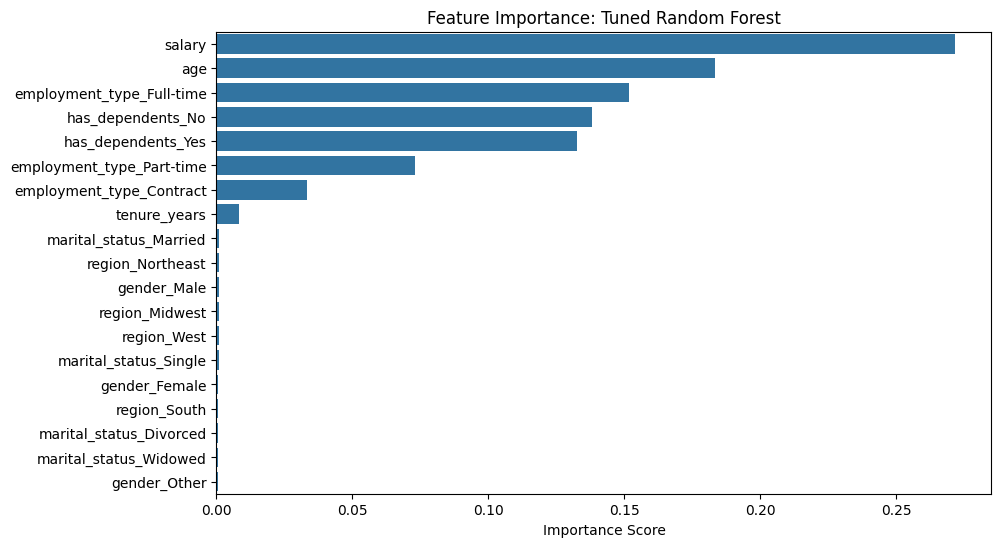

In [ ]:
# Plot for RF
plot_feature_importance(models["Tuned Random Forest"], "Tuned Random Forest", all_features)

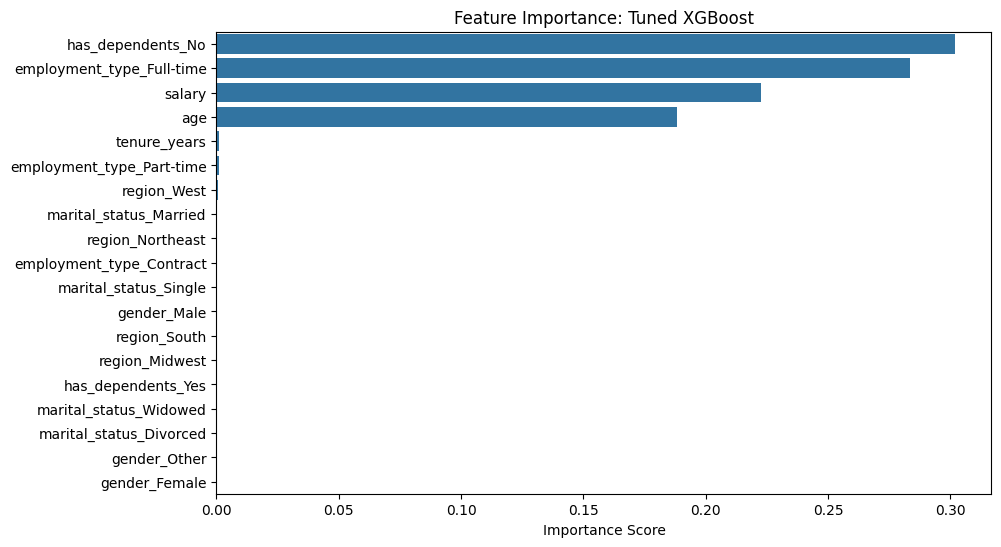

In [ ]:
# Plot for XGB
plot_feature_importance(models["Tuned XGBoost"], "Tuned XGBoost", all_features)

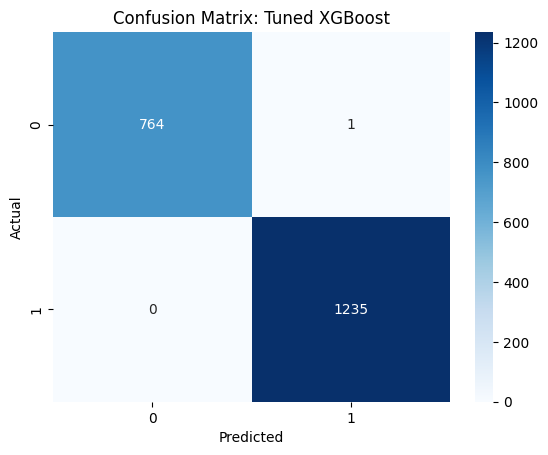

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix: {name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
mlflow.log_param("model", name)
mlflow.log_metric("accuracy", acc)
mlflow.log_metric("f1_score", f1)
mlflow.sklearn.log_model(model, "model")
mlflow.end_run()

2025/05/06 23:19:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


**Load Best Model from MLflow**

In [ ]:
client = MlflowClient()
experiment = client.get_experiment_by_name("Default")
runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["metrics.accuracy DESC"],
    max_results=1
)

In [ ]:
best_run_id = runs[0].info.run_id
best_model_uri = f"runs:/{best_run_id}/model"
best_mlflow_model = mlflow.sklearn.load_model(best_model_uri)

In [ ]:
def predict_enrollment(model_pipeline, employee_dict):
    employee_df = pd.DataFrame([employee_dict])
    return model_pipeline.predict(employee_df)[0], model_pipeline.predict_proba(employee_df)[0][1]


**Testing with Sample Data**

In [ ]:
sample = {
    "age": 35,
    "gender": "Female",
    "marital_status": "Single",
    "salary": 72000,
    "employment_type": "Full-time",
    "region": "West",
    "has_dependents": "No",
    "tenure_years": 4.2
}

In [ ]:
best_model = xgb_search.best_estimator_
pred, prob = predict_enrollment(best_model, sample)
print(f"Predicted: {'Enrolled' if pred == 1 else 'Not Enrolled'} (Probability: {prob:.2f})")

Predicted: Enrolled (Probability: 1.00)
